In [1]:
using Distributed
using SharedArrays
#TODO: move to JLD2
using JLD
using DelimitedFiles
using LinearAlgebra
using GenericLinearAlgebra
using Combinatorics
using TOML          # used for input
using Printf
using ForwardDiff
using Query
#using Roots         # used to find lambda
using IntervalArithmetic, IntervalRootFinding
using StaticArrays
using PaddedViews   # used to pad fft arrays
using FFTW          # used for convolutions
include("$(@__DIR__)/src/Config.jl")
include("$(@__DIR__)/src/helpers.jl")
include("$(@__DIR__)/src/IO.jl")
include("$(@__DIR__)/src/dispersion.jl")
include("$(@__DIR__)/src/GFTools.jl")
include("$(@__DIR__)/src/ladderDGATools.jl")
include("$(@__DIR__)/src/dbg_ladderDGATools.jl")
include("$(@__DIR__)/src/GFFit.jl")
include("$(@__DIR__)/src/lambdaCorrection.jl")

configFile = "config_tc_cut.toml"
const loadFromBak = false
print("Reading Inputs...")
modelParams, simParams, env, Γch, Γsp, Σ_loc, FUpDo, χLocch, χLocsp, usable_loc_ch, usable_loc_sp = setup_LDGA(configFile)
println(size.([Γch, Γsp, Σ_loc, FUpDo])...)
println(simParams)
println("\rInputs Read. Starting Computation.
Found usable intervals for local susceptibility of length 
      sp: $(length(usable_loc_sp))
      ch: $(length(usable_loc_ch)) 
      χLoc_sp = $(printr_s(χLocsp)), χLoc_ch = $(printr_s(χLocch))")

println("Setting up and calculating k Grid: ")
kIndices, kGrid = gen_kGrid(simParams.Nk, modelParams.D) 
ϵkGrid          = squareLattice_ekGrid(kGrid)
qIndices, qGrid = reduce_kGrid.(cut_mirror.((kIndices, kGrid)))
qMultiplicity   = kGrid_multiplicity(qIndices)

println("Calculating bubble: ")
@time bubble = calc_bubble_fft(Σ_loc, ϵkGrid, length(qIndices), modelParams, simParams);

println("Calculating χ and γ: ")
#@time χsp_f, χch_f, χsp_ω_f, χch_ω_f, trilexsp_f, trilexch_f,  usable_sp_f, usable_ch_f  =
#           calc_χ_trilex(Γsp, Γch, bubble, qMultiplicity, modelParams, simParams, true)
@time χsp, χch, χsp_ω, χch_ω, trilexsp, trilexch,  usable_sp, usable_ch =
           calc_χ_trilex(Γsp, Γch, bubble, qMultiplicity, modelParams, simParams)

#@time χsp2,trilexsp2 = calc_χ_trilex(Γsp, bubble, modelParams, simParams, Usign= -1)
#@time χch2,trilexch2 = calc_χ_trilex(Γch, bubble, modelParams, simParams, Usign= 1)
usable_ω = intersect(usable_sp, usable_ch)

println("Found usable intervals for non-local susceptibility of length 
      sp: $(usable_sp), length: $(length(usable_sp))
      ch: $(usable_ch), length: $(length(usable_ch))
      usable: $(usable_ω), length: $(length(usable_ω))")

if simParams.tail_corrected
    χch_sum = approx_full_sum(χch_ω[usable_ch], [1])[1]/(modelParams.β)
    rhs = 0.5 - real(χch_sum)
    println("Using rhs for tail corrected lambda correction: ", printr_s(rhs), " = 0.5 - ", printr_s(χch_sum))
else
    χsp_sum = sum(χsp_ω[usable_loc_sp])/(modelParams.β)
    χch_sum = sum(χch_ω[usable_loc_ch])/(modelParams.β)
    rhs = real(χLocsp + χLocch - χch_sum)
    println("Using rhs for non tail corrected lambda correction: 
      ", round(real(rhs),digits=4), " = ", round(real(χLocch),digits=4), 
      " + ", round(real(χLocsp),digits=4), " - ", round(real(χch_sum),digits=4))
end

println("Calculating λ correction in the spin channel: ")
@time λsp = calc_λ_correction(χsp[usable_sp,:], rhs, qMultiplicity, simParams, modelParams)
println("Found λsp = ", λsp)

println("computing λ corrected χsp, using ", simParams.χFillType, " as fill value outside usable ω range.")
χsp_λ = zeros(eltype(χsp), size(χsp)...)
if simParams.χFillType == zero_χ_fill
    χsp_λ[usable_sp,:] =  χ_λ(χsp[usable_sp,:], λsp) 
elseif simParams.χFillType == lambda_χ_fill
    χsp_λ =  χ_λ(χsp, λsp) 
else
    χsp_λ =  χsp 
    χsp_λ[usable_sp,:] =  χ_λ(χsp[usable_sp,:], λsp); 
end;

Reading Inputs...

┌ Info: Reading Fortran Input, this can take several minutes.
└ @ Main /home/julian/Hamburg/LadderDGA/src/IO.jl:84
┌ Info: Done Reading Gamma
└ @ Main /home/julian/Hamburg/LadderDGA/src/IO.jl:98
┌ Info: Done Reading chi
└ @ Main /home/julian/Hamburg/LadderDGA/src/IO.jl:100
┌ Info: loading from 
│   env.inputVars = vars.jld
└ @ Main /home/julian/Hamburg/LadderDGA/src/helpers.jl:163
┌ Warning: TODO: check beta consistency, config <-> g0man, chi_dir <-> gamma dir
└ @ Main /home/julian/Hamburg/LadderDGA/src/helpers.jl:171


(81, 82, 82)(81, 82, 82)(81,)(81, 82, 82)
SimulationParameters(41, 40, 0, 20, true, false, false, false, zero_χ_fill, false, "FFT")
Inputs Read. Starting Computation.
Found usable intervals for local susceptibility of length 
      sp: 29
      ch: 35 
      χLoc_sp = 0.0609, χLoc_ch = 0.4573
Setting up and calculating k Grid: 
Calculating bubble: 
  2.787220 seconds (7.78 M allocations: 1.495 GiB, 6.73% gc time)
Calculating χ and γ: 
 67.903882 seconds (46.92 M allocations: 18.583 GiB, 2.03% gc time)
Found usable intervals for non-local susceptibility of length 
      sp: 30:52, length: 23
      ch: 24:58, length: 35
      usable: 30:52, length: 23


MethodError: MethodError: no method matching approx_full_sum(::Array{Complex{Float64},1}, ::Array{Int64,1})
Closest candidates are:
  approx_full_sum(::Any; W, fast) at /home/julian/Hamburg/LadderDGA/src/GFFit.jl:172

In [4]:
function calc_bubble_fft(Σ::Array{Complex{Float64},1}, ϵkGrid::Base.Generator, redGridSize::Int64,
                              modelParams, simParams)

LoadError: syntax: incomplete: premature end of input

In [5]:
ϵkGrid

Base.Generator{Base.Iterators.ProductIterator{Tuple{Array{Float64,1},Array{Float64,1},Array{Float64,1}}},var"#89#90"{Base.Iterators.ProductIterator{Tuple{Array{Float64,1},Array{Float64,1},Array{Float64,1}}}}}(var"#89#90"{Base.Iterators.ProductIterator{Tuple{Array{Float64,1},Array{Float64,1},Array{Float64,1}}}}(Base.Iterators.ProductIterator{Tuple{Array{Float64,1},Array{Float64,1},Array{Float64,1}}}(([-2.827433388230814, -2.5132741228718345, -2.199114857512855, -1.8849555921538759, -1.5707963267948966, -1.2566370614359172, -0.9424777960769379, -0.6283185307179586, -0.3141592653589793, 0.0, 0.3141592653589793, 0.6283185307179586, 0.9424777960769379, 1.2566370614359172, 1.5707963267948966, 1.8849555921538759, 2.199114857512855, 2.5132741228718345, 2.827433388230814, 3.141592653589793], [-2.827433388230814, -2.5132741228718345, -2.199114857512855, -1.8849555921538759, -1.5707963267948966, -1.2566370614359172, -0.9424777960769379, -0.6283185307179586, -0.3141592653589793, 0.0, 0.31415926535

In [212]:
cnf = "config2.toml"
disable_logging(Logging.Info)
include("src/LadderDGA.jl")
bubble, χch, χsp, χsp_λ, usable_sp, usable_ch, trilexch, trilexsp, Σ_ladder = calculate_Σ_ladder(cnf);

Writing HDF5 (vars.jdl) and Fortran (fortran_out/) output.


┌ Warning: TODO: check beta consistency, config <-> g0man, chi_dir <-> gamma dir
└ @ Main ~/Hamburg/LadderDGA/src/helpers.jl:171


  0.419101 seconds (664.47 k allocations: 53.631 MiB)
  1.929853 seconds (581.78 k allocations: 268.102 MiB, 4.08% gc time)
  0.728833 seconds (1.38 M allocations: 61.503 MiB)
  0.826199 seconds (2.76 M allocations: 234.370 MiB, 5.40% gc time)


In [213]:
using Plots
plot(imag.(Σ_ladder[:,1]))
include("src/IO.jl")
writeFortranΣ("../ladderDGA3D_FFT",Σ_ladder)

In [188]:
size(χch)

(21, 56)

In [129]:
cnf_tc_cut = "config_tc_cut.toml"
cnf_ntc_cut = "config_ntc_cut.toml"
cnf_ntc_full = "config_ntc_full.toml"
include("src/LadderDGA.jl")
bubble_tc_cut, χch_tc_cut, χsp_tc_cut, χsp_λ_tc_cut, usable_sp_tc_cut, usable_ch_tc_cut, trilexch_tc_cut, trilexsp_tc_cut, Σ_ladder_tc_cut = calculate_Σ_ladder(cnf_tc_cut);
bubble_ntc_cut, χch_ntc_cut, χsp_ntc_cut, χsp_λ_ntc_cut, usable_sp_ntc_cut, usable_ch_ntc_cut, trilexch_ntc_cut, trilexsp_ntc_cut, Σ_ladder_ntc_cut = calculate_Σ_ladder(cnf_ntc_cut);
bubble_ntc_full, χch_ntc_full, χsp_ntc_full, χsp_λ_ntc_full, usable_sp_ntc_full, usable_ch_ntc_full, trilexsp_ntc_full, trilexsp_ntc_full, Σ_ladder_ntc_full = calculate_Σ_ladder(cnf_ntc_full);

[ Info: Reading Inputs...
[ Info: Reading Fortran Input, this can take several minutes.
[ Info: Done Reading Gamma
[ Info: Done Reading chi
┌ Info: loading from 
└   env.inputVars = "vars.jld"
┌ Warning: TODO: check beta consistency, config <-> g0man, chi_dir <-> gamma dir
└ @ Main ~/Hamburg/LadderDGA/src/helpers.jl:171
┌ Info: Inputs Read. Starting Computation.
│ Found usable intervals for local susceptibility of length 
│       sp: 35
│       ch: 29 
└       χLoc_sp = 0.4573, χLoc_ch = 0.0609
[ Info: Setting up and calculating k Grid: 
[ Info: Calculating bubble: 


  1.873447 seconds (4.62 M allocations: 1.345 GiB, 10.64% gc time)


[ Info: Calculating χ and γ: 


132.560993 seconds (37.93 M allocations: 18.078 GiB, 1.67% gc time)


┌ Info: Found usable intervals for non-local susceptibility of length 
│ sp: 24:58, length: 35
│ ch: 30:52, length: 23
└ usable: 30:52, length: 23
┌ Info: Using rhs for tail corrected lambda correction: 
│   rhs = 0.4413520121593384
│    = 0.5 -  = " = 0.5 - "
└   χch_sum = 0.05864798784066162 - 9.177109351783457e-24im
[ Info: Calculating λ correction in the spin channel: 
┌ Info: found 
│   χ_min = 0.0864667252938756
│   . Looking for roots in intervall  = ". Looking for roots in intervall "
│   int =
│    2-element Array{Float64,1}:
│     0.0863417252938756
└     0.1364667252938756


  2.539944 seconds (9.57 M allocations: 382.386 MiB, 3.59% gc time)


┌ Info: possible roots: 
│   r =
│    2-element Array{Root{Interval{Float64}},1}:
│     Root([0.0864667, 0.0864669], :unknown)
└     Root([0.0866909, 0.086691], :unique)
┌ Info: Found λsp 
└   λsp = 0.0866909885432397
┌ Info: computing λ corrected χsp, using 
│   simParams.χFillType = zero_χ_fill::ChiFillType = 0
└    as fill value outside usable ω range. = " as fill value outside usable ω range."
[ Info: Calculating Σ ladder: 
┌ Info: using ω range: 
└   ωlist = 30:52


  4.354756 seconds (17.72 M allocations: 2.728 GiB, 10.69% gc time)


[ Info: Reading Inputs...
[ Info: Reading Fortran Input, this can take several minutes.
[ Info: Done Reading Gamma
[ Info: Done Reading chi
┌ Info: loading from 
└   env.inputVars = "vars.jld"
┌ Warning: TODO: check beta consistency, config <-> g0man, chi_dir <-> gamma dir
└ @ Main ~/Hamburg/LadderDGA/src/helpers.jl:171
┌ Info: Inputs Read. Starting Computation.
│ Found usable intervals for local susceptibility of length 
│       sp: 13
│       ch: 11 
└       χLoc_sp = 0.3836, χLoc_ch = 0.0203
[ Info: Setting up and calculating k Grid: 
[ Info: Calculating bubble: 


  1.352684 seconds (4.10 M allocations: 1.321 GiB, 13.86% gc time)


[ Info: Calculating χ and γ: 


 44.201433 seconds (469.81 k allocations: 3.574 GiB, 0.82% gc time)


┌ Info: Found usable intervals for non-local susceptibility of length 
│ sp: 35:47, length: 13
│ ch: 36:46, length: 11
└ usable: 36:46, length: 11
┌ Info: Using rhs for non tail corrected lambda correction: 
│   rhs = 0.38456386666690834
│    =  = " = "
│   χLocch = 0.020276848711585176 - 2.757268708510092e-26im
│    +  = " + "
│   χLocsp = 0.3835975010915569 - 1.9300880959570646e-25im
│    -  = " - "
└   χch_sum = 0.019310483136233743 + 5.514537417020184e-26im
[ Info: Calculating λ correction in the spin channel: 
┌ Info: found 
│   χ_min = 0.09308728251371533
│   . Looking for roots in intervall  = ". Looking for roots in intervall "
│   int =
│    2-element Array{Float64,1}:
│     0.09296228251371533
└     0.14308728251371533


  0.213463 seconds (1.24 M allocations: 48.836 MiB)


┌ Info: possible roots: 
│   r =
│    1-element Array{Root{Interval{Float64}},1}:
└     Root([0.0933347, 0.0933348], :unique)
┌ Info: Found λsp 
└   λsp = 0.09333478802648582
┌ Info: computing λ corrected χsp, using 
│   simParams.χFillType = zero_χ_fill::ChiFillType = 0
└    as fill value outside usable ω range. = " as fill value outside usable ω range."
[ Info: Calculating Σ ladder: 
┌ Info: using ω range: 
└   ωlist = 36:46


  1.515006 seconds (8.34 M allocations: 1.337 GiB, 11.08% gc time)


[ Info: Reading Inputs...
[ Info: Reading Fortran Input, this can take several minutes.
[ Info: Done Reading Gamma
[ Info: Done Reading chi
┌ Info: loading from 
└   env.inputVars = "vars.jld"
┌ Warning: TODO: check beta consistency, config <-> g0man, chi_dir <-> gamma dir
└ @ Main ~/Hamburg/LadderDGA/src/helpers.jl:171
┌ Info: Inputs Read. Starting Computation.
│ Found usable intervals for local susceptibility of length 
│       sp: 13
│       ch: 11 
└       χLoc_sp = 0.3836, χLoc_ch = 0.0203
[ Info: Setting up and calculating k Grid: 
[ Info: Calculating bubble: 


  1.646889 seconds (4.10 M allocations: 1.321 GiB, 7.69% gc time)


[ Info: Calculating χ and γ: 


215.847887 seconds (1.81 M allocations: 19.008 GiB, 0.27% gc time)


┌ Info: Found usable intervals for non-local susceptibility of length 
│ sp: 35:47, length: 13
│ ch: 36:46, length: 11
└ usable: 36:46, length: 11
┌ Info: Using rhs for non tail corrected lambda correction: 
│   rhs = 0.38456386666690834
│    =  = " = "
│   χLocch = 0.020276848711585176 - 2.757268708510092e-26im
│    +  = " + "
│   χLocsp = 0.3835975010915569 - 1.9300880959570646e-25im
│    -  = " - "
└   χch_sum = 0.019310483136233743 + 5.514537417020184e-26im
[ Info: Calculating λ correction in the spin channel: 
┌ Info: found 
│   χ_min = 0.09308728251371533
│   . Looking for roots in intervall  = ". Looking for roots in intervall "
│   int =
│    2-element Array{Float64,1}:
│     0.09296228251371533
└     0.14308728251371533


  0.210089 seconds (1.24 M allocations: 48.836 MiB)


┌ Info: possible roots: 
│   r =
│    1-element Array{Root{Interval{Float64}},1}:
└     Root([0.0933347, 0.0933348], :unique)
┌ Info: Found λsp 
└   λsp = 0.09333478802648582
┌ Info: computing λ corrected χsp, using 
│   simParams.χFillType = lambda_χ_fill::ChiFillType = 1
└    as fill value outside usable ω range. = " as fill value outside usable ω range."
[ Info: Calculating Σ ladder: 
┌ Info: using ω range: 
└   ωlist = 1:81


  9.949944 seconds (55.14 M allocations: 9.099 GiB, 10.02% gc time)


In [164]:
mP = modelParams
sP = simParams
norm = mP.U / (mP.β * (sP.Nk^mP.D))
Gνω = [G_fft(ind, Σ_loc, ϵkGrid, mP.β, mP.μ) for ind in (-sP.n_iω):(sP.n_iν+sP.n_iω)]
Σ_ladder = zeros(eltype(χch), sP.n_iν, length(qIndices))
ωlist = sP.fullSums ? (1:(2*sP.n_iω+1)) : usable_ω
ωlist = 30:52
println(ωlist)
νlist = 
#println("TODO: qMult instead of expansion")

for ωi in ωlist
    for νi in 1:12
        Kνωq = (1.5 .* trilexsp[ωi, :, νi+sP.n_iν] .* (1 .+ mP.U*χsp[ωi, :]) .-
               0.5 .* trilexch[ωi, :, νi+sP.n_iν].* (1 .- mP.U*χch[ωi, :]) .- 1.5 .+ 0.5) .+
               sum(bubble[ωi,:,vpi] .* FUpDo[ωi,νi+sP.n_iν,vpi] for vpi = 1:12)
        Kνωq = expand_kGrid(qIndices, Kνωq)
        Kνωq = fft(Kνωq)
        Σ_ladder[νi, :] += norm .* reduce_kGrid(ifft_cut_mirror(ifft(Kνωq .* Gνω[νi + ωi - 1])))
    end
end


30:52


In [163]:
length(-11:11)

23

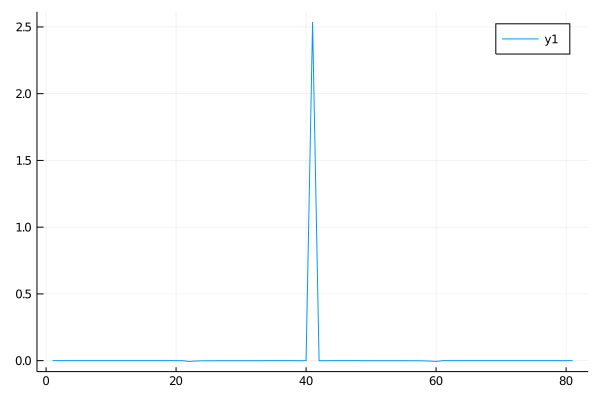

In [156]:
plot(real.(χsp[:,1]))

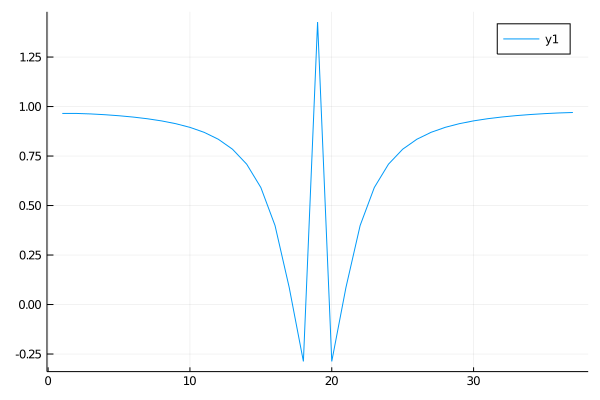

In [146]:

trilexsp_ων = zeros(Complex{Float64}, size(trilexsp,1),size(trilexsp,3))
trilexch_ων = zeros(Complex{Float64}, size(trilexch,1),size(trilexch,3))

for ωi in 1:size(trilexsp_ων,1)
    for νi in 1:size(trilexsp_ων,3)
trilexsp_ων[ωi,νi] = sum(trilexsp[ωi,:,νi] .* qMultiplicity) / (qNorm)
trilexch_ων[ωi,νi] = sum(trilexch[ωi,:,νi] .* qMultiplicity) / (qNorm)

    end
end
plot(real.(trilexch[42,end,23:59]))

0.0

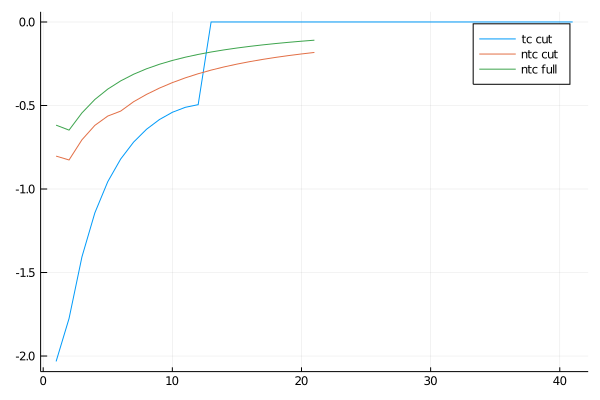

In [166]:
plot(imag.(Σ_ladder[1:41,1]), label="tc cut")
#plot!(imag.(Σ_ladder[1:21,end]))
plot!(imag.(Σ_ladder_ntc_cut[1:21,1]), label="ntc cut")
plot!(imag.(Σ_ladder_ntc_full[1:21,1]), label="ntc full")

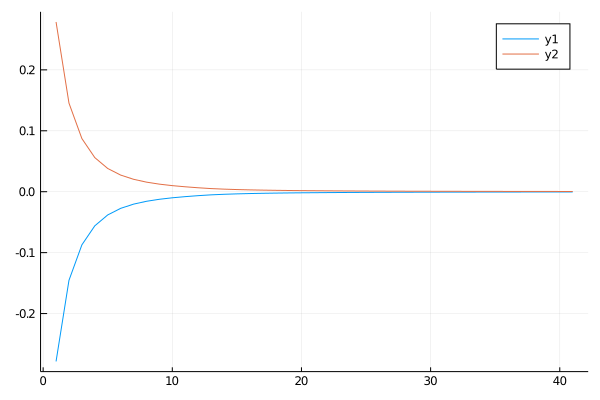

In [79]:
plot(real.(Σ_ladder[:,1]))
plot!(real.(Σ_ladder[:,end]))

In [47]:
qNorm = 8*(Int(simParams.Nk/2))^(modelParams.D)
χsp_ω = [sum(χsp[ωi,:] .* qMultiplicity) / (qNorm) for ωi in 1:size(χsp,1)];
χch_ω = [sum(χch[ωi,:] .* qMultiplicity) / (qNorm) for ωi in 1:size(χch,1)];

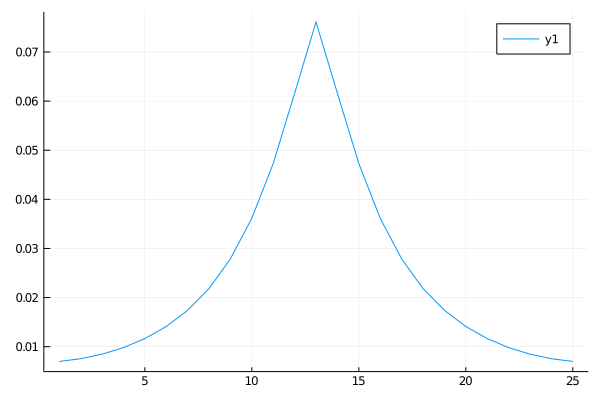

In [51]:
#plot(real.(χsp_ω))
plot(real.(χch_ω[usable_ch]))

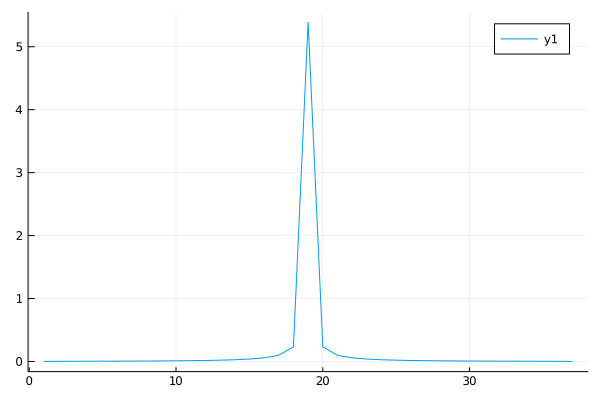

In [53]:
plot(real.(χsp_ω[usable_sp]))

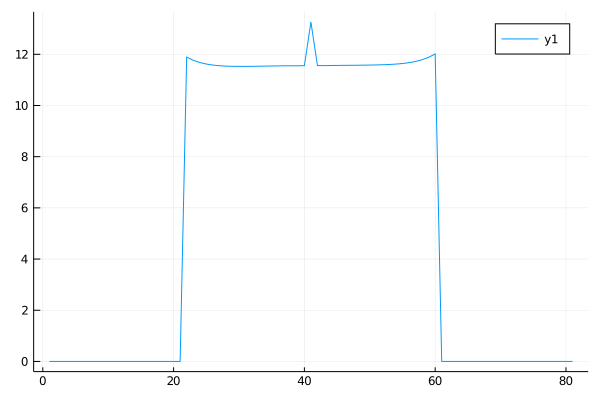

In [60]:
plot(real.(trilexch[:,1,end]))

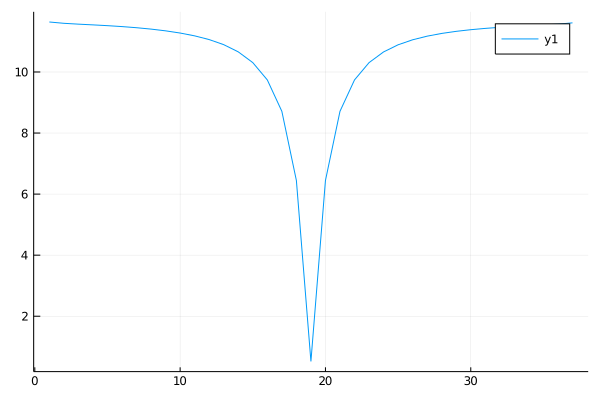

In [67]:
plot(real.(trilexsp[usable_sp,end,end]))

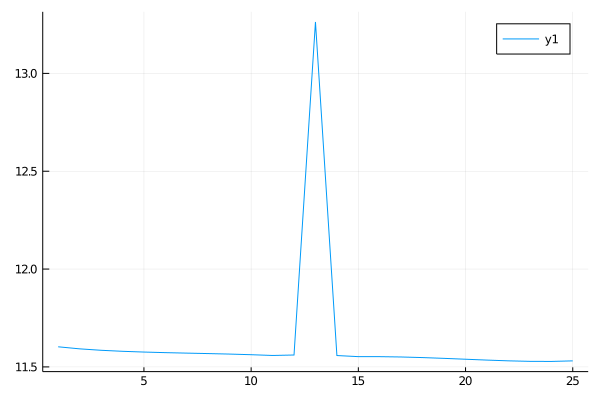

In [66]:
plot(real.(trilexch[usable_ch,1,1]))